In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

In [0]:
!pip install -U feather-format
!pip install fastai
!pip install -U seaborn

In [0]:
from fastai.tabular import *

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime
import feather
import os

import warnings
warnings.simplefilter(action='ignore')

PATH='/content/drive/My Drive/Colab Notebooks/'

%matplotlib inline

## Task: forecast (quarterly) sales

---

Idea: the final day a car is listed on CarMax is the day it is sold.

To test the idea, the following hypothesis is formed:  171,076 cars are sold between March and May 2016. The figure is based on page 26 of the [10Q](http://d1lge852tjjqow.cloudfront.net/CIK-0001170010/19db8b54-bd72-4706-8283-623089d29c63.pdf) by CarMax.

We shall find out if this is true by creating a dataframe only with entries from March to May 2016.

In [4]:
%%time
df = feather.read_dataframe('/content/drive/My Drive/Colab Notebooks/dataset/kmx_test_processed.feather')

# before_period = df[df['date_added'] < datetime.date(2016,3,1)]['url'].tolist()
after_period = df[df['date_added'] > datetime.date(2016,5,31)]['url'].tolist()
during_period = df[(df['date_added'] <= datetime.date(2016,5,31)) & 
                   (df['date_added'] >= datetime.date(2016,3,1))]['url'].tolist()

period_df = df[(df['url'].isin(during_period)) & 
               (~df['url'].isin(after_period)) & 
               (df['date_added'] <= datetime.date(2016,5,31)) & 
               (df['date_added'] >= datetime.date(2016,3,1))]

feather.write_dataframe(period_df, '/content/drive/My Drive/Colab Notebooks/dataset/period_df.feather')

CPU times: user 11 s, sys: 1.43 s, total: 12.4 s
Wall time: 12.8 s


In [0]:
df = feather.read_dataframe('/content/drive/My Drive/Colab Notebooks/dataset/period_df.feather')

# change date_added to pandas datetime object
# since feather cannot read datetime
df['date_added'] = pd.to_datetime(df['date_added'])

In [0]:
# check that none of the entries appear more than the number of days
grouped = df.groupby('url').size()
grouped.sort_values(ascending=False)[:10]

df = df.groupby('url').tail(1)

In [7]:
# count unique ids
df['url'].nunique()

165934

We only have 165,934 of unique IDs, which correspond to the number of vehicles sold between March and May 2016, close enough to 171,076!

In [8]:
# number of vehicles listed each day
df['date_added'].value_counts().sort_index()[:10]

2016-03-01    1830
2016-03-02    1753
2016-03-03    1800
2016-03-04    2066
2016-03-05    3457
2016-03-06    1567
2016-03-07    2502
2016-03-08     969
2016-03-09    1916
2016-03-10    1834
Name: date_added, dtype: int64

In [9]:
tail_df = df.groupby('url').tail(1)
sum(tail_df['price'])

3350894231.9599996

The total sales from March to May is 3,350,894,231 USD while the 10Q reported 3,428,974 USD.

Hypothesis holds fairly well. Let us extend to the whole dataset.

In [0]:
df = feather.read_dataframe('/content/drive/My Drive/Colab Notebooks/dataset/kmx_head.feather')

# change date_added to pandas datetime object
# since feather cannot read datetime
df['date_added'] = pd.to_datetime(df['date_added'])

In [11]:
df = df[df['make'].notnull()]
df.isnull().sum()

url            0
date_added     0
price          0
year           0
make           0
model          0
mileage        0
region         0
days_listed    0
dtype: int64

In [12]:
df.head()

,url,date_added,price,year,make,model,mileage,region,days_listed
0,12346985,2015-10-06,21599.0,2012,Acura,TSX,16000,"Columbia, SC",15
1,12377212,2015-10-06,14599.0,2013,Dodge,Dart SE,18000,"Los Angeles, CA",75
2,12141829,2015-10-06,33998.0,2014,Toyota,FJ Cruiser,18000,"Houston, TX",83
3,12271909,2015-10-06,19599.0,2014,Toyota,Camry SE,5000,"Tinley Park, IL",12
4,11951142,2015-10-06,14998.0,2009,Honda,Accord EX-L,56000,"Hillside, IL",35


It is not known whether the cars listed on the final day were sold, hence, we remove cars that appear on the last day.

In [0]:
temp = df['days_listed'].apply(lambda x: pd.Timedelta(x, unit='D'))
df['sold_date'] = df['date_added'] + temp

df = df[df['sold_date'] < datetime.date(2017,6,15)]

The start date of our dataset is 2015-10-06 and end date is 2017-06-14.

In [0]:
START_DATE = datetime.date(2015,10,6)
END_DATE = datetime.date(2017,6,14)

How many cars are listed for 1 day?

In [15]:
df[df['days_listed'] == 1].shape[0]

52137

## More EDA

In [16]:
df.nunique()

url            1249984
date_added         599
price             2898
year                15
make                40
model             2552
mileage            132
region             308
days_listed        366
sold_date          626
dtype: int64

We have 1,250,006 unique entries in our dataset, collected for 599 days across cars sold in 308 regions. 

In [17]:
mean_days_listed = df['days_listed'].mean()
median_days_listed = df['days_listed'].median()

mean_days_listed, median_days_listed

(25.563672815012033, 17.0)

The average days it takes to sell a car is 26 while the median is 17.

Out of the 40 make, which is the most popular?

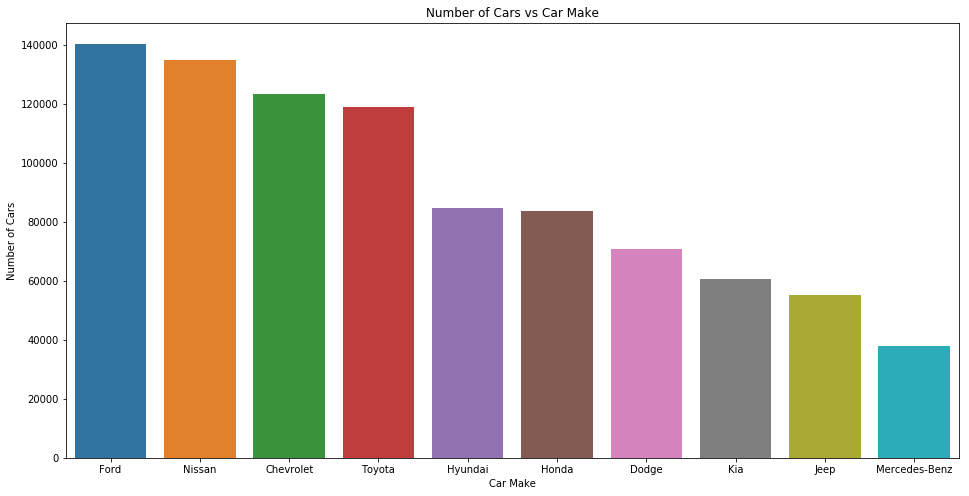

In [18]:
df_grouped_make = df.groupby('make')
make_vs_url = df_grouped_make['url'].agg(lambda x:len(x.unique()))
make_vs_url = df_grouped_make['url'].nunique()
make_vs_url = make_vs_url.sort_values(ascending=False)

plt.figure(figsize=(16,8))
sns.barplot(make_vs_url.index, make_vs_url.values,
            order=make_vs_url.iloc[:10].index)

plt.xlabel('Car Make')
plt.ylabel('Number of Cars')
plt.title('Number of Cars vs Car Make')
plt.show()

Are cheaper cars more popular?

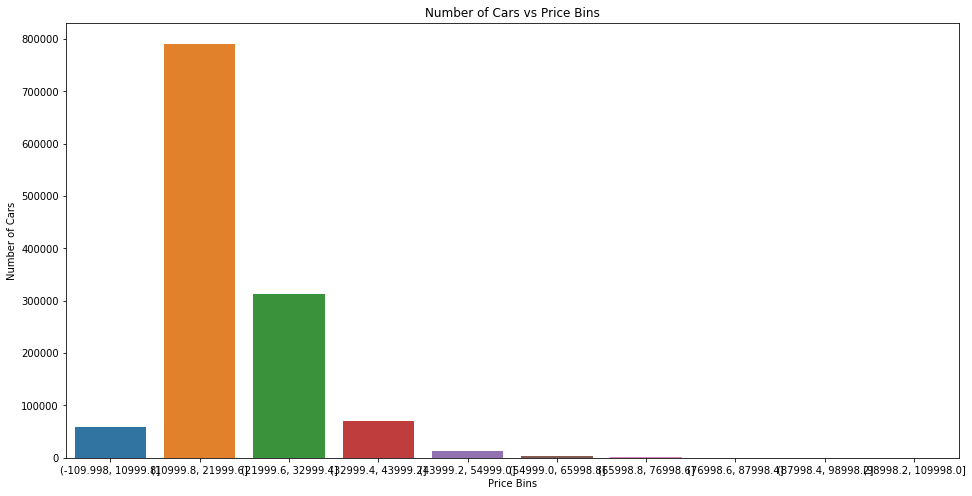

In [19]:
cars_bin_df = df

cars_bin_df['bucket'] = pd.cut(cars_bin_df['price'], 10)
range_bucket_df = cars_bin_df['bucket'].value_counts()
cars_bin_df.drop('bucket', axis=1, inplace=True)

plt.figure(figsize=(16,8))
sns.barplot(range_bucket_df.index, range_bucket_df.values)

plt.xlabel('Price Bins')
plt.ylabel('Number of Cars')
plt.title('Number of Cars vs Price Bins')
plt.show()

In [20]:
range_bucket_df

(10999.8, 21999.6]     791147
(21999.6, 32999.4]     313610
(32999.4, 43999.2]      69403
(-109.998, 10999.8]     58868
(43999.2, 54999.0]      12970
(54999.0, 65998.8]       2832
(65998.8, 76998.6]        872
(76998.6, 87998.4]        220
(87998.4, 98998.2]         55
(98998.2, 109998.0]         7
Name: bucket, dtype: int64

Cars having price ranging from 11,000 USD to 33,000 USD are most popular.

What is the trend for car sales?

In [0]:
cars_day_df = df

temp = cars_day_df['days_listed'].apply(lambda x: pd.Timedelta(x, unit='D'))
cars_day_df['sold_date'] = cars_day_df['date_added'] + temp

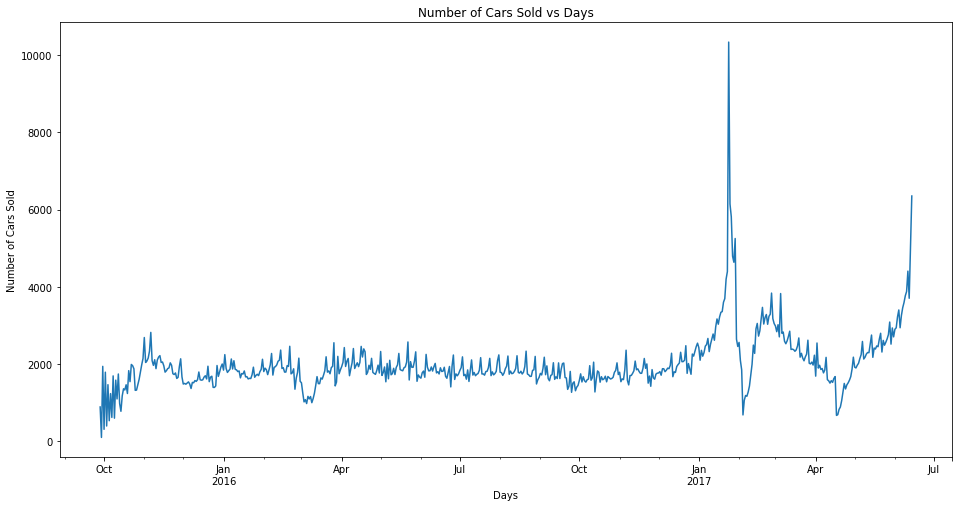

In [22]:
sales_trend = cars_day_df['sold_date'].value_counts().sort_index()

plt.figure(figsize=(16,8))
sales_trend.plot()

plt.xlabel('Days')
plt.ylabel('Number of Cars Sold')
plt.title('Number of Cars Sold vs Days')
plt.show()

10,339 cars were sold on 2017-01-24, which is unusual.

In [23]:
sales_trend.sort_values(ascending=False)[:10]

2017-01-24    10339
2017-06-14     6352
2017-01-25     6147
2017-01-26     5814
2017-01-29     5251
2017-06-13     4981
2017-01-27     4792
2017-01-28     4636
2017-06-11     4406
2017-01-23     4396
Name: sold_date, dtype: int64

Assuming the last day a car is listed is the day it is sold, which day has the best sales?

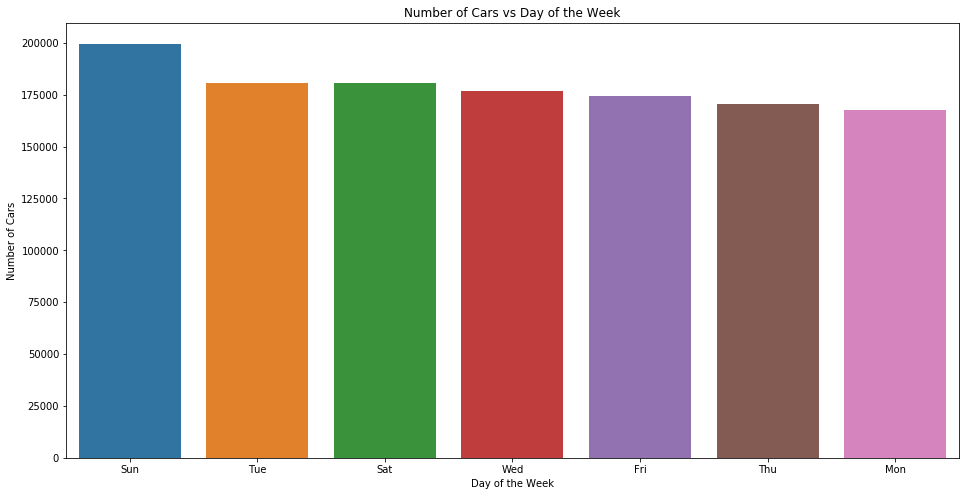

In [24]:
cars_day_df['weekday'] = cars_day_df['sold_date'].apply(lambda x: x.weekday())

days_dict = {0: 'Mon', 1: 'Tue', 2: 'Wed',
             3: 'Thu', 4: 'Fri', 5: 'Sat',
             6: 'Sun'}

tmp_df = cars_day_df['weekday'].apply(lambda x: days_dict[x]).value_counts()

plt.figure(figsize=(16,8))
sns.barplot(tmp_df.index, 
            tmp_df.values)

plt.xlabel('Day of the Week')
plt.ylabel('Number of Cars')
plt.title('Number of Cars vs Day of the Week')
plt.show()

del cars_day_df, tmp_df

Most cars were sold on Sunday.

Which region has the best sales?

In [25]:
cars_bin_df['region'].value_counts()[:10]

Norcross                  22334
Ontario                   18291
Texas Stadium (Irving)    17117
Fredericksburg            17016
Columbia                  17002
Lancaster                 16759
Hartford                  16264
Austin North              15748
Arlington/Ft. Worth       14999
Oxnard                    14865
Name: region, dtype: int64

Norcross seems to have the best sales, followed by Ontario

## Feature Engineering

In [0]:
df = df.drop(828364)
df['price_per_mile'] = df['price']/df['mileage']
df['price_per_mile'].replace(np.inf, 999, inplace=True)

# # can we group regions?
# df['code'] = df['region'].str.split(', ').str[1]
# df.drop('code', axis=1, inplace=True)

df['age'] = df['date_added'].dt.year - df['year'] + 1
df.drop('year', axis=1, inplace=True)

In [27]:
df.head()

,url,date_added,price,make,model,mileage,region,days_listed,sold_date,weekday,price_per_mile,age
0,12346985,2015-10-06,21599.0,Acura,TSX,16000,"Columbia, SC",15,2015-10-21,2,1.349938,4
1,12377212,2015-10-06,14599.0,Dodge,Dart SE,18000,"Los Angeles, CA",75,2015-12-20,6,0.811056,3
2,12141829,2015-10-06,33998.0,Toyota,FJ Cruiser,18000,"Houston, TX",83,2015-12-28,0,1.888778,2
3,12271909,2015-10-06,19599.0,Toyota,Camry SE,5000,"Tinley Park, IL",12,2015-10-18,6,3.919800,2
4,11951142,2015-10-06,14998.0,Honda,Accord EX-L,56000,"Hillside, IL",35,2015-11-10,1,0.267821,7


## Can we build a model to predict how long does it take to sell a car?

---

Let us split our dataset in terms of time, having training data from 12/2015 to 08/2016 and test data from 9/2016 to 11/2016. These dates align with CarMax's 10-Q. We then try to estimate the sales for our test data.

In [0]:
TRAIN_START_DATE = datetime.date(2015,12,1) # 10-Q ended 11/2015
TRAIN_END_DATE = datetime.date(2016,8,31) # 10-Q ended 8/2015

TEST_START_DATE = datetime.date(2016,9,1)
TEST_END_DATE = datetime.date(2016,11,30)

In [0]:
train_df = df[(df['sold_date'] >= TRAIN_START_DATE) &
              (df['sold_date'] <= TRAIN_END_DATE)]

test_df = df[(df['sold_date'] >= TEST_START_DATE) &
             (df['sold_date'] <= TEST_END_DATE)]

train_df.drop(['sold_date'], axis=1, inplace=True)
test_df.drop(['sold_date'], axis=1, inplace=True)

train_df.to_pickle(f"{PATH}/clean_train.pkl")
test_df.to_pickle(f"{PATH}/clean_test.pkl")

In [0]:
from fastai.tabular import *

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime
import feather

import warnings
warnings.simplefilter(action='ignore')

PATH='/content/drive/My Drive/Colab Notebooks/'

%matplotlib inline

train_df = pd.read_pickle(f"{PATH}clean_train.pkl")
test_df = pd.read_pickle(f"{PATH}clean_test.pkl")

In [31]:
train_df.shape[0], test_df.shape[0]
train_df.head()

,url,date_added,price,make,model,mileage,region,days_listed,weekday,price_per_mile,age
1,12377212,2015-10-06,14599.0,Dodge,Dart SE,18000,"Los Angeles, CA",75,6,0.811056,3
2,12141829,2015-10-06,33998.0,Toyota,FJ Cruiser,18000,"Houston, TX",83,0,1.888778,2
7,11804450,2015-10-06,13599.0,Kia,Rio LX,11000,"Augusta, GA",56,1,1.236273,1
10,12150992,2015-10-06,29998.0,Ford,Flex Limited,15000,"Austin, TX",80,4,1.999867,2
15,12444872,2015-10-06,15998.0,Dodge,Dart Rallye,17000,"Lancaster, PA",102,5,0.941059,3


In [0]:
procs=[FillMissing, Categorify, Normalize]

cat_var = ['make', 'model', 'region', 'age']

con_var = ['price', 'mileage', 'price_per_mile']

In [33]:
y = 'days_listed'

# reorder for train_df
df = train_df[cat_var + con_var + [y, 'date_added']].copy()
df.head()

,make,model,region,age,price,mileage,price_per_mile,days_listed,date_added
1,Dodge,Dart SE,"Los Angeles, CA",3,14599.0,18000,0.811056,75,2015-10-06
2,Toyota,FJ Cruiser,"Houston, TX",2,33998.0,18000,1.888778,83,2015-10-06
7,Kia,Rio LX,"Augusta, GA",1,13599.0,11000,1.236273,56,2015-10-06
10,Ford,Flex Limited,"Austin, TX",2,29998.0,15000,1.999867,80,2015-10-06
15,Dodge,Dart Rallye,"Lancaster, PA",3,15998.0,17000,0.941059,102,2015-10-06


In [34]:
test_df = test_df[cat_var + con_var + [y, 'date_added', 'url']].copy()

actual_days_listed = test_df['days_listed']
test_df.drop('days_listed', axis=1, inplace=True)

test_df.head()

,make,model,region,age,price,mileage,price_per_mile,date_added,url
148,Nissan,Murano,Austin South,10,15599.0,55000,0.283618,2016-03-07,12264269
3371,Kia,Optima EX,"Lynchburg, VA",2,18998.0,20000,0.949900,2015-10-14,11781859
4343,Kia,Optima Hybrid LX,"Milwaukee, WI",2,17998.0,27000,0.666593,2015-10-14,12157847
5350,Toyota,Venza,"Omaha, NE",7,16998.0,59000,0.288102,2015-10-14,11842824
8409,Nissan,Maxima,Ft. Lauderdale,7,17998.0,53000,0.339585,2016-03-06,12068270


In [35]:
test_df['date_added'].min(), test_df['date_added'].max()

(Timestamp('2015-09-27 00:00:00'), Timestamp('2016-11-29 00:00:00'))

In [0]:
cut = train_df['date_added'][(train_df['date_added'] == train_df['date_added'][len(test_df) - 10])].index.max()

In [0]:
valid_idx = range(cut)

In [38]:
df[y].head()

1      75
2      83
7      56
10     80
15    102
Name: days_listed, dtype: int64

In [0]:
data = (TabularList.from_df(df, 
                            path=PATH, 
                            cat_names=cat_var, 
                            cont_names=con_var, 
                            procs=procs)
                   .split_by_idx(valid_idx)
                   .label_from_df(cols=y, label_cls=FloatList)
                   .add_test(ItemList.from_df(test_df,
                                              PATH))
                   .databunch())

## Model

In [0]:
max_log_y = np.max(train_df[y])*1.2
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [41]:
y_range

tensor([  0.0000, 385.2000], device='cuda:0')

In [0]:
learn = tabular_learner(data, layers=[1000,500], 
                        ps=[0.001,0.01], 
                        emb_drop=0.04, 
                        y_range=y_range, 
                        metrics=mse)

In [43]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(41, 13)
    (1): Embedding(2586, 130)
    (2): Embedding(311, 40)
    (3): Embedding(15, 7)
  )
  (emb_drop): Dropout(p=0.04)
  (bn_cont): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=193, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.01)
    (8): Linear(in_features=500, out_features=1, bias=True)
  )
)

In [44]:
len(data.train_ds.cont_names)

3

In [45]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 9.12E-03


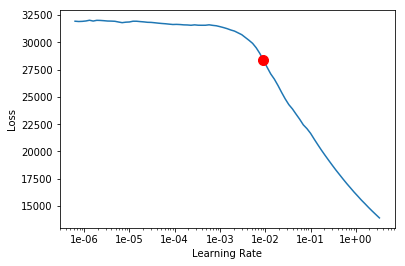

In [46]:
learn.recorder.plot()

In [47]:
learn.fit_one_cycle(1, 1e-3, wd=0.2)

epoch,train_loss,valid_loss,mean_squared_error
1,425.114105,2532.755371,2532.755859


In [0]:
learn.save('8')

In [0]:
# learn.recorder.plot_losses(last=-1)

In [50]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)
test_df[y] = preds.data.numpy().T[0]
test_df.head()

,make,model,region,age,price,mileage,price_per_mile,date_added,url,days_listed
148,Nissan,Murano,Austin South,10,-0.635786,0.666427,-0.086009,2016-03-07,12264269,32.340958
3371,Kia,Optima EX,"Lynchburg, VA",2,-0.204150,-0.713351,-0.077102,2015-10-14,11781859,21.625734
4343,Kia,Optima Hybrid LX,"Milwaukee, WI",2,-0.331139,-0.437396,-0.080889,2015-10-14,12157847,35.391743
5350,Toyota,Venza,"Omaha, NE",7,-0.458128,0.824116,-0.085949,2015-10-14,11842824,21.174271
8409,Nissan,Maxima,Ft. Lauderdale,7,-0.331139,0.587583,-0.085261,2016-03-06,12068270,24.993774


## Can we predict sales for CarMax?

---
We attempt to predict how many days does it take to sell a car from the day it is first listed and then we proceed to forecast monthly sales for CarMax.



In [0]:
df = test_df

First, add the predicted days to the first day the car was listed to see when it was sold.

In [52]:
temp = df['days_listed'].apply(lambda x: pd.Timedelta(x, unit='D'))
df['sold_date'] = df['date_added'] + temp
df['sold_date'] = df['sold_date'].dt.date

df.head()

,make,model,region,age,price,mileage,price_per_mile,date_added,url,days_listed,sold_date
148,Nissan,Murano,Austin South,10,-0.635786,0.666427,-0.086009,2016-03-07,12264269,32.340958,2016-04-08
3371,Kia,Optima EX,"Lynchburg, VA",2,-0.204150,-0.713351,-0.077102,2015-10-14,11781859,21.625734,2015-11-04
4343,Kia,Optima Hybrid LX,"Milwaukee, WI",2,-0.331139,-0.437396,-0.080889,2015-10-14,12157847,35.391743,2015-11-18
5350,Toyota,Venza,"Omaha, NE",7,-0.458128,0.824116,-0.085949,2015-10-14,11842824,21.174271,2015-11-04
8409,Nissan,Maxima,Ft. Lauderdale,7,-0.331139,0.587583,-0.085261,2016-03-06,12068270,24.993774,2016-03-30


Filter the data to only contain cars that were assumed to be sold between 9/2016 and 11/2016 and then return to the original test data to retrieve their prices.

In [0]:
predicted_df = df[(df['sold_date'] >= datetime.date(2016, 9, 1)) &
                  (df['sold_date'] <= datetime.date(2016, 11, 30))]

actual_test_df = pd.read_pickle(f"{PATH}clean_test.pkl")

expected_cars_ids = predicted_df['url'].tolist()

expected_cars_df = actual_test_df[actual_test_df['url'].isin(expected_cars_ids)]

In [54]:
expected_cars_df.shape[0]

128530

The model only predicted 128,530 cars would be sold in the 3 months, quite a good estimation compared to 156,789 (from page 22 of [10-Q](http://d18rn0p25nwr6d.cloudfront.net/CIK-0001170010/da35a153-543f-41c1-a41c-683c66175a52.pdf)).

## Second attempt: fbprophet!

---

Can we instead, just predict the car sales each day?

In [0]:
from fbprophet import Prophet
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime
import feather

import warnings
warnings.simplefilter(action='ignore')

In [56]:
df = feather.read_dataframe('/content/drive/My Drive/Colab Notebooks/dataset/kmx_head.feather')

df['date_added'] = pd.to_datetime(df['date_added'])
temp = df['days_listed'].apply(lambda x: pd.Timedelta(x, unit='D'))
df['sold_date'] = df['date_added'] + temp


df.head()

,url,date_added,price,year,make,model,mileage,region,days_listed,sold_date
0,12346985,2015-10-06,21599.0,2012,Acura,TSX,16000,"Columbia, SC",15,2015-10-21
1,12377212,2015-10-06,14599.0,2013,Dodge,Dart SE,18000,"Los Angeles, CA",75,2015-12-20
2,12141829,2015-10-06,33998.0,2014,Toyota,FJ Cruiser,18000,"Houston, TX",83,2015-12-28
3,12271909,2015-10-06,19599.0,2014,Toyota,Camry SE,5000,"Tinley Park, IL",12,2015-10-18
4,11951142,2015-10-06,14998.0,2009,Honda,Accord EX-L,56000,"Hillside, IL",35,2015-11-10


In [57]:
sales_trend = df['sold_date'].value_counts().sort_index()

sales_df = pd.DataFrame({'sold_date': sales_trend.index,
                         'num_sales': sales_trend.values})

median = sales_df.loc[(sales_df['num_sales'] < 3000) & 
                      (sales_df['num_sales'] > 1000), 
                      'num_sales'].median()

sales_df["num_sales"] = np.where((sales_df["num_sales"] > 3000) |
                                 (sales_df["num_sales"] < 1000), 
                                  median, 
                                  sales_df['num_sales'])

# sales_df = sales_df[(sales_df['num_sales'] < 3000) & 
#                     (sales_df['num_sales'] > 1000)]

sales_df = sales_df[sales_df['sold_date'] < datetime.date(2017,2,1)]

sales_df['sold_date'] = sales_df['sold_date'].dt.date


sales_df.tail()

,num_sales,sold_date
487,1826.0,2017-01-27
488,1826.0,2017-01-28
489,1826.0,2017-01-29
490,2643.0,2017-01-30
491,2455.0,2017-01-31


In [58]:
sales_df.columns = ['y', 'ds']
sales_df.head()

train = sales_df[:400]
test = sales_df[400:]

actual_y = test['y']
actual_y[:5]

400    1787.0
401    1542.0
402    1615.0
403    1596.0
404    1847.0
Name: y, dtype: float64

In [59]:
test.head()

,y,ds
400,1787.0,2016-11-01
401,1542.0,2016-11-02
402,1615.0,2016-11-03
403,1596.0,2016-11-04
404,1847.0,2016-11-05


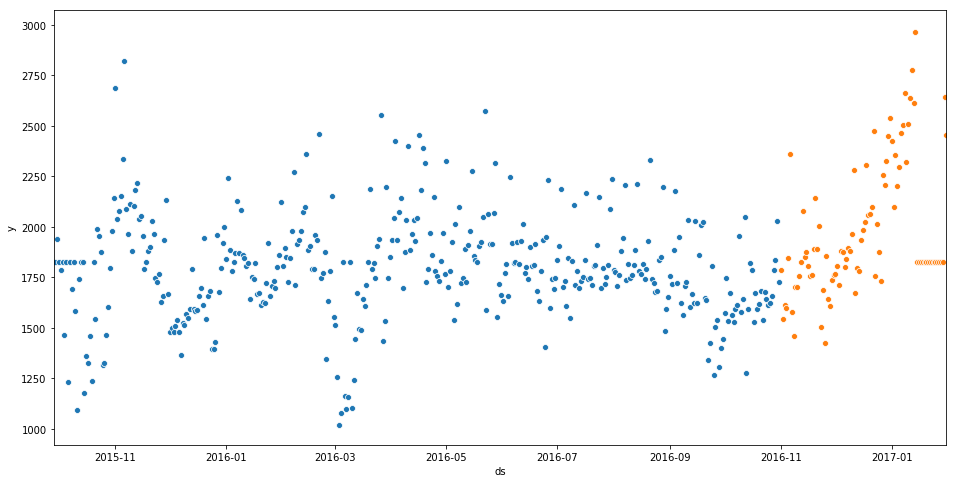

In [60]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 8)

ax = sns.scatterplot(x=train.ds, y=train.y)
ax = sns.scatterplot(x=test.ds, y=test.y)

ax.axes.set_xlim(train.ds.min(), test.ds.max());

In [61]:
%%time
train['cap'] = train.y.max()
train['floor'] = train.y.min()

m = Prophet(growth='logistic', 
            changepoints=['2016-10-31'], 
            changepoint_prior_scale=0.01, 
            interval_width=0.8) 

m.add_seasonality(name='monthly', period=30.5, fourier_order=1)
m.add_seasonality(name='quarterly', period=91.25, fourier_order=5, prior_scale=0.1)
m.add_seasonality(name='yearly', period=365.25, fourier_order=10)

m.fit(train)

INFO:fbprophet:Found custom seasonality named "yearly", disabling built-in yearly seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CPU times: user 28.2 s, sys: 81.9 ms, total: 28.3 s
Wall time: 28.3 s


In [62]:
future = m.make_future_dataframe(periods=12, freq='W')
future['cap'] = 1.4 #approx max for last year same period
future['floor'] = train.y.min()

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
407,2016-12-25,691.924355,467.225137,929.022867
408,2017-01-01,808.746008,585.669861,1034.896297
409,2017-01-08,855.530322,632.272012,1095.599443
410,2017-01-15,785.896830,574.973342,994.666431
411,2017-01-22,667.525190,430.405366,894.677626


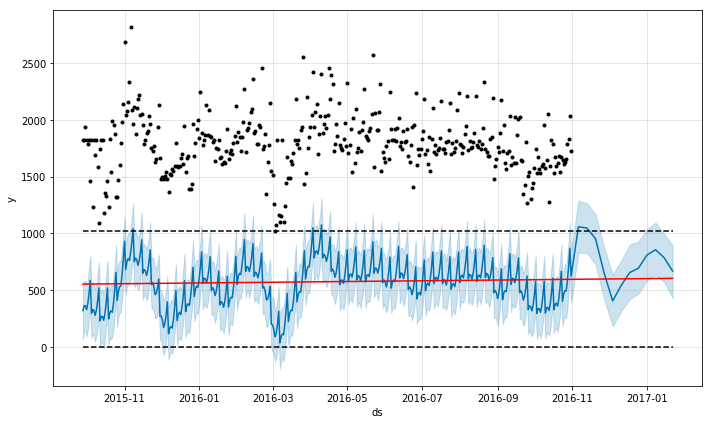

In [63]:
from  fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

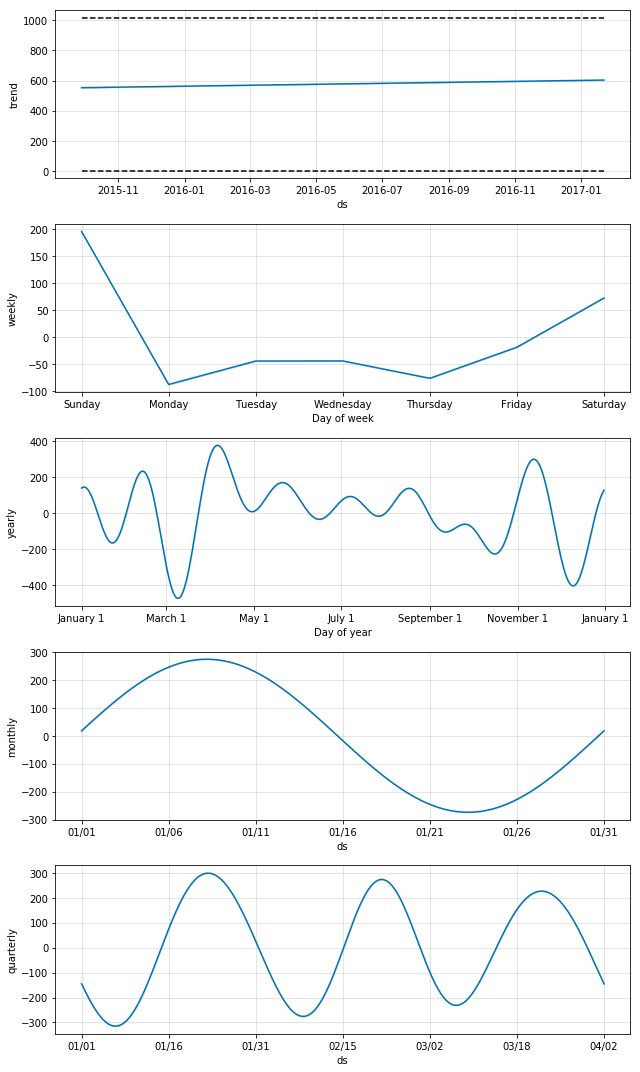

In [64]:
fig2 = m.plot_components(forecast);

In [65]:
test = pd.concat([test.set_index('ds'),forecast.set_index('ds')], axis=1, join='inner')

cols = ['yhat', 'yhat_lower', 'yhat_upper']
test['yhat'] = (test.yhat).round(2)
test['yhat_lower'] = (test.yhat_lower).round(2)
test['yhat_upper'] = (test.yhat_upper).round(2)

np.asarray(test['yhat'].tolist()[:5]) - np.asarray(actual_y[:5].tolist())

array([ -729.15,  -495.55,  -662.24,  -945.42, -1442.81])

Unfortunately, the predicted car sales for the first day is off by 729 compared to the actual sales.

## Conclusion: Our neural network helped us forecast sales by CarMax fairly accurately. In addition, we can still check for missing entries from the page on a monthly basis to forecast CarMax's monthly sales.